In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import GPy
import random
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error as mse
from emukit.core import ParameterSpace, ContinuousParameter
from emukit.model_wrappers import GPyModelWrapper
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, \
                                                      NegativeLowerConfidenceBound, \
                                                      MaxValueEntropySearch, \
                                                      ProbabilityOfImprovement
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
def myplot(y_true_list, y_pred_list,var_list, title_str_list, color_list,region):
    fig, axes = plt.subplots(1, 2, figsize=(5.5*2, 4.5))
    fs = 18
    
    for i in range(len(axes)):
        axes[i].scatter(y_true_list[i], y_pred_list[i], alpha = 0.6, c = color_list[i])
        axes[i].plot(region,region, 'k--', alpha=0.75, zorder=0)
        axes[i].errorbar(y_true_list[i],y_pred_list[i], yerr = var_list[i], ms = 0, 
                 ls = '', capsize = 2, alpha = 0.6,
                 color = 'gray', zorder = 0)
        axes[i].set_xlabel('Ground Truth', fontsize = fs)
        axes[i].set_ylabel('Prediction', fontsize = fs)
        axes[i].set_xlim(region)
        axes[i].set_ylim(region)
        rmse = mse(y_true_list[i],y_pred_list[i],squared=False)
        title = title_str_list[i] + " (RMSE = %.3f)"%rmse
        axes[i].set_title(title, fontsize = fs)
        axes[i].grid(True, linestyle='-.')

In [3]:
# 参数空间
Tip_Height_min, Tip_Height_max, Tip_Height_step = [0.5, 50, 0.5]
Tip_Height_var = np.arange(Tip_Height_min, Tip_Height_max+0.1*Tip_Height_step,Tip_Height_step)
Tip_Height_num = len(Tip_Height_var)

Dispense_Speed_AS_min, Dispense_Speed_AS_max, Dispense_Speed_AS_step = [20,500,10]
Dispense_Speed_AS_var = np.arange(Dispense_Speed_AS_min, Dispense_Speed_AS_max+0.1*Dispense_Speed_AS_step,Dispense_Speed_AS_step)
Dispense_Speed_AS_num = len(Dispense_Speed_AS_var)

Spin_Speed_AS_min, Spin_Speed_AS_max, Spin_Speed_AS_step = [500,7000,100]
Spin_Speed_var = np.arange(Spin_Speed_AS_min,Spin_Speed_AS_max+0.1*Spin_Speed_AS_step,Spin_Speed_AS_step)
Spin_Speed_num = len(Spin_Speed_var)

Volume_AS_min, Volume_AS_max, Volume_AS_step = [50,300,10]
Volume_AS_var = np.arange(Volume_AS_min, Volume_AS_max+0.1*Volume_AS_step, Volume_AS_step)
Volume_AS_num = len(Volume_AS_var)

Timing_AS_min, Timing_AS_max, Timing_AS_step = [2,25,1]
Timing_AS_var = np.arange(Timing_AS_min, Timing_AS_max+0.1*Timing_AS_step,Timing_AS_step)
Timing_AS_num = len(Timing_AS_var)

x_label=[
    'Tip_Height',
    'Dispense_Speed_AS',
    'Spin_Speed_AS',
    'Volume_AS',
    'Timing_AS'
]

var_array = [
    Tip_Height_var,
    Dispense_Speed_AS_var,
    Spin_Speed_var,
    Volume_AS_var,
    Timing_AS_var
]


def x_normalizer(X, var_array = var_array):
    
    def max_min_scaler(x, x_max, x_min):
        return (x-x_min)/(x_max-x_min)
    x_norm = []
    for x in (X):
           x_norm.append([max_min_scaler(x[i], 
                         max(var_array[i]), 
                         min(var_array[i])) for i in range(len(x))])
            
    return np.array(x_norm)

def x_denormalizer(x_norm, var_array = var_array):
    
    def max_min_rescaler(x, x_max, x_min):
        return x*(x_max-x_min)+x_min
    x_original = []
    for x in (x_norm):
           x_original.append([max_min_rescaler(x[i], 
                              max(var_array[i]), 
                              min(var_array[i])) for i in range(len(x))])

    return np.array(x_original)


def get_closest_array(suggested_x):
    
    def get_closest_value(given_value, array_list):
        absolute_difference_function = lambda list_value : abs(list_value - given_value)
        closest_value = min(array_list, key=absolute_difference_function)
        return closest_value
    
    var_list = var_array
    modified_array = []
    for x in suggested_x:
        modified_array.append([get_closest_value(x[i], var_list[i]) for i in range(len(x))])
    return np.array(modified_array)

In [5]:
data  = pd.read_excel('../高斯过程.xlsx',usecols=[i for i in range(1,9)],sheet_name='round1').dropna()
Data = data.values

X = Data[:,:5]
Y = Data[:,6]

X_norm = x_normalizer(X)
ss_y = 0.3
Y_norm = Y/ss_y 

Train_X, Test_X, Train_y, Test_y = train_test_split(X_norm, Y_norm, test_size = 0.3,random_state=1)


In [6]:
Y_norm

array([0.57921036, 1.03121747, 0.39792063, 0.75839459, 0.48327929,
       0.41032203, 0.33075321, 0.33081659, 0.11184334, 0.2000958 ,
       0.75826963, 0.21736726, 0.17069694, 0.32581634, 0.11564557,
       0.14920296])

In [5]:
data

,Tip Height \n(mm) 0.5-50,Dispense Speed \n(ul/s) 20-500,AS Spin Speed \n(rpm) 500-7000,AS Volume \n(ul) 50-300,Timing AS\n (s) 2-25,PL Intensity ave,PL Intensity CV,Peak CV,PLQY
0,1.5,90.0,5600.0,50.0,12.0,175357.061097,0.173763,0.001152,0.337201
1,20.0,460.0,2300.0,220.0,25.0,178837.692437,0.309365,0.001924,0.333660
2,4.0,250.0,7000.0,300.0,22.0,324724.062188,0.119376,0.000455,0.325180
3,8.0,260.0,4900.0,100.0,5.0,251923.044783,0.227518,0.000707,0.321183
4,15.5,170.0,5100.0,70.0,7.0,228986.076923,0.144984,0.000439,0.335772
5,29.5,380.0,5800.0,100.0,13.0,241866.564743,0.123097,0.001060,0.310272
6,32.0,450.0,800.0,140.0,15.0,188744.000000,0.099226,0.000456,0.393455
7,50.0,200.0,1700.0,110.0,6.0,245398.692308,0.099245,0.000540,0.444454


In [6]:
Train_y

array([0.75839459, 0.48327929, 0.41032203, 0.33075321, 0.33081659])

In [12]:
rbf = GPy.kern.RBF(input_dim=5, variance=1., lengthscale=1.,ARD=True)
linear = GPy.kern.Linear(input_dim=5,ARD =True)
m52 = GPy.kern.Matern52(input_dim = 5, ARD =True)
m52.lengthscale.constrain_bounded(1e-2, 1)
m52.variance.constrain_bounded(1e-1, 1000.0)

kernel = m52
model_gpy = GPy.models.GPRegression(Train_X,Train_y.reshape(-1,1),kernel)

model_gpy.randomize()
model_gpy.optimize_restarts(num_restarts = 50)
model_gpy.optimize(messages=True)

y_pred_train = model_gpy.predict(Train_X)[0].ravel()
y_pred_test = model_gpy.predict(Test_X)[0].ravel()
var_train = np.sqrt(model_gpy.predict(Train_X)[1]).ravel()
var_test = np.sqrt(model_gpy.predict(Test_X)[1]).ravel()

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


Optimization restart 1/50, f = 4.5423717588689545
Optimization restart 2/50, f = 4.560853507269505
Optimization restart 3/50, f = 4.560853790550785
Optimization restart 4/50, f = 4.542373754518172
Optimization restart 5/50, f = 4.542371758659797
Optimization restart 6/50, f = 4.560860527919827
Optimization restart 7/50, f = 4.560853495184972
Optimization restart 8/50, f = 4.56085460017161
Optimization restart 9/50, f = 4.562377498344619
Optimization restart 10/50, f = 4.56085602221538
Optimization restart 11/50, f = 6.2942854654294464
Optimization restart 12/50, f = 4.560853644391207
Optimization restart 13/50, f = 4.562379786392868
Optimization restart 14/50, f = 4.56238086546214
Optimization restart 15/50, f = 4.560855322329827
Optimization restart 16/50, f = 7.5475788163436555
Optimization restart 17/50, f = 4.560855568301119
Optimization restart 18/50, f = 4.562371441896395
Optimization restart 19/50, f = 4.560854316579908
Optimization restart 20/50, f = 4.560853623151667
Optimizat

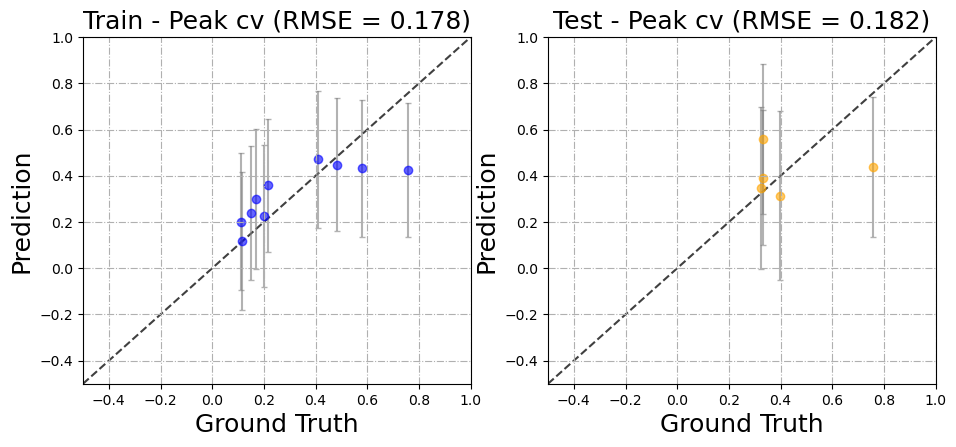

In [13]:
myplot([Train_y,Test_y],[y_pred_train,y_pred_test],[var_train,var_test],
       ["Train - Peak cv","Test - Peak cv"],
       ["blue","orange"],
      [-0.5,1])
#plt.savefig('result',dpi=1000)

In [14]:
X_normalize = x_normalizer(Data[:,:5])
Y_normalize = Data[:,6]/ss_y

rbf =  GPy.kern.RBF(input_dim=5, variance=1., lengthscale=1.,ARD=True)
linear = GPy.kern.Linear(input_dim=5,ARD =True)

m52 = GPy.kern.Matern52(input_dim = 5, ARD =True)
m52.lengthscale.constrain_bounded(1e-2, 1)
m52.variance.constrain_bounded(1e-1, 1000.0)

kernel = m52
model = GPy.models.GPRegression(X_normalize,Y_normalize.reshape(-1,1),kernel)

model.randomize()
model.optimize_restarts(num_restarts = 50)
model.optimize(messages=True)

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


Optimization restart 1/50, f = 4.172367030012026
Optimization restart 2/50, f = 4.172369020194541
Optimization restart 3/50, f = 4.172366605700108
Optimization restart 4/50, f = 4.172366231857627
Optimization restart 5/50, f = 4.17236617816538
Optimization restart 6/50, f = 4.172366290988865
Optimization restart 7/50, f = 4.172370042144855
Optimization restart 8/50, f = 4.1723666622899955
Optimization restart 9/50, f = 4.1723672654082025
Optimization restart 10/50, f = 4.172368772204488
Optimization restart 11/50, f = 4.172367396286305
Optimization restart 12/50, f = 4.172367616605569
Optimization restart 13/50, f = 4.172366226275175
Optimization restart 14/50, f = 4.172366167373486
Optimization restart 15/50, f = 4.17236790686709
Optimization restart 16/50, f = 4.1723679337886885
Optimization restart 17/50, f = 4.17236758625055
Optimization restart 18/50, f = 4.1723744421438145
Optimization restart 19/50, f = 4.172366245849151
Optimization restart 20/50, f = 4.1723734379693544
Optimiz

0.16921936314408323


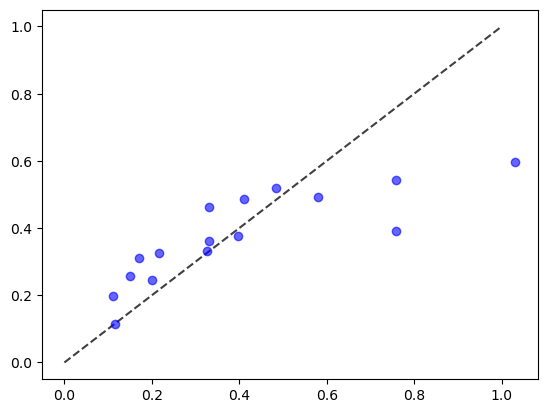

In [15]:
y_pred = model.predict(X_normalize)[0]
plt.scatter(Y_normalize,y_pred,c='b',alpha=0.6)
plt.plot([0,1],[0,1], 'k--', alpha=0.75, zorder=0)
print(mse(Y_normalize,y_pred,squared=False))

In [16]:
parameter_space = ParameterSpace([ContinuousParameter('Tip_Height', 0-1/(Tip_Height_num-1)/2, 1+1/(Tip_Height_num-1)/2),
                                  ContinuousParameter('Dispense_Speed_AS', 0-1/(Dispense_Speed_AS_num-1)/2, 1+1/(Dispense_Speed_AS_num-1)/2),
                                  ContinuousParameter('Spin_Speed', 0-1/(Spin_Speed_num-1)/2, 1+1/(Spin_Speed_num-1)/2),
                                  ContinuousParameter('Volume_AS', 0-1/(Volume_AS_num-1)/2, 1+1/(Volume_AS_num-1)/2),
                                  ContinuousParameter('Timing_AS', 0-1/(Timing_AS_num-1)/2, 1+1/(Timing_AS_num-1)/2)
                                  
                                  ])
parameter_space.parameters

[ContinuousParameter(Tip_Height, -0.005050505050505051, 1.005050505050505),
 ContinuousParameter(Dispense_Speed_AS, -0.010416666666666666, 1.0104166666666667),
 ContinuousParameter(Spin_Speed, -0.007692307692307693, 1.0076923076923077),
 ContinuousParameter(Volume_AS, -0.02, 1.02),
 ContinuousParameter(Timing_AS, -0.021739130434782608, 1.0217391304347827)]

In [17]:
np.random.seed(1000)

objective_model = GPyModelWrapper(model)
bs = 3


acquisition = NegativeLowerConfidenceBound(objective_model, beta = 1)#NegativeLowerConfidenceBound(objective_model, beta = beta[i])#ExpectedImprovement(objective_model, jitter=.1)#NegativeLowerConfidenceBound(objective_model, beta = 1)

bayesopt= BayesianOptimizationLoop(model=objective_model, 
                                   space=parameter_space, 
                                   acquisition=acquisition,
                                   batch_size = bs)


X_new = bayesopt.candidate_point_calculator.compute_next_points(bayesopt.loop_state)
x = get_closest_array(x_denormalizer(X_new,var_array))
df_Xnew = pd.DataFrame(x, columns = x_label)
u = ss_y*model.predict(x_normalizer(x))[0]
sigma = ss_y*model.predict(x_normalizer(x))[1]
pred = pd.DataFrame(np.append(u,sigma,axis=1),columns=['pred_mean','pred_sigma'])
final = pd.concat([df_Xnew, pred], axis=1)
final


1000000


 D:\Anaconda\lib\site-packages\emukit-0.4.10-py3.9.egg\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log


Init point :  [0.73919563 0.64152092 0.89232351 0.39387236 0.26655369]
opt point :  (array([[ 1.00505051, -0.01041667,  1.00769231,  1.02      , -0.02173913]]), array([[0.52931375]]))
acq_max =  [[-0.52931375]]
Init point :  [0.83891896 0.87731819 0.64103966 0.94482679 0.63793445]
opt point :  (array([[0.83891896, 0.87731819, 0.64103966, 0.94482679, 0.63793445]]), array([[nan]]))
acq_max =  [[nan]]
Init point :  [0.39293273 0.82394282 0.54611808 0.32101797 0.70990324]
opt point :  (array([[0.39293273, 0.82394282, 0.54611808, 0.32101797, 0.70990324]]), array([[nan]]))
acq_max =  [[nan]]


,Tip_Height,Dispense_Speed_AS,Spin_Speed_AS,Volume_AS,Timing_AS,pred_mean,pred_sigma
0,50.0,20.0,7000.0,300.0,2.0,0.021099,0.022895
1,42.0,440.0,4700.0,290.0,17.0,0.136661,0.016588
2,20.0,420.0,4000.0,130.0,18.0,0.106177,0.019680


In [18]:
final.to_excel('Intensity cv2_gp.xlsx')

In [21]:
rp

array([[0.        , 0.68421053, 0.        , 0.31111111, 1.        ],
       [1.        , 0.36842105, 0.        , 0.37777778, 1.        ],
       [1.        , 0.81578947, 0.        , 0.53333333, 1.        ]])

In [9]:
X_new

array([[ 1.00505051,  0.81757072, -0.00714286,  0.54268288,  1.01724138]])

In [13]:
np.random.seed(1000)

objective_model = GPyModelWrapper(model)
bs = 10


acquisition = NegativeLowerConfidenceBound(objective_model, beta = 1)#ExpectedImprovement(objective_model, jitter=beta[i])#NegativeLowerConfidenceBound(objective_model, beta = beta[i])#ExpectedImprovement(objective_model, jitter=.1)#NegativeLowerConfidenceBound(objective_model, beta = 1)

bayesopt= BayesianOptimizationLoop(model=objective_model, 
                                   space=parameter_space, 
                                   acquisition=acquisition,
                                   batch_size = bs)


X_new = bayesopt.candidate_point_calculator.compute_next_points(bayesopt.loop_state)



1000000


 D:\Anaconda\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1
 D:\Anaconda\lib\site-packages\emukit-0.4.10-py3.9.egg\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log


Init point :  [0.46538428 0.14189202 0.20669397 0.79520894 0.14463125]
opt point :  (array([[0.46538428, 0.14189202, 0.20669397, 0.79520894, 0.14463125]]), array([[nan]]))
acq_max =  [[nan]]
Init point :  [0.40654548 0.65703494 0.76346659 0.34727138 0.48632265]
opt point :  (array([[0.40654548, 0.65703494, 0.76346659, 0.34727138, 0.48632265]]), array([[nan]]))
acq_max =  [[nan]]
Init point :  [0.12557292 0.40128067 0.79426988 0.73709175 0.88406021]
opt point :  (array([[0.12557292, 0.40128067, 0.79426988, 0.73709175, 0.88406021]]), array([[nan]]))
acq_max =  [[nan]]
Init point :  [0.37678209 0.36536233 0.96221431 0.80144208 0.06896802]
opt point :  (array([[0.37678209, 0.36536233, 0.96221431, 0.80144208, 0.06896802]]), array([[nan]]))
acq_max =  [[nan]]
Init point :  [0.23571933 0.96419597 0.47947772 0.2150342  0.19346971]
opt point :  (array([[0.23571933, 0.96419597, 0.47947772, 0.2150342 , 0.19346971]]), array([[nan]]))
acq_max =  [[nan]]
Init point :  [0.47399726 0.37574806 0.038228

In [14]:
x = get_closest_array(x_denormalizer(X_new,var_array))
df_Xnew = pd.DataFrame(x, columns = x_label)
u = ss_y*model.predict(x_normalizer(x))[0]
sigma = ss_y*model.predict(x_normalizer(x))[1]
pred = pd.DataFrame(np.append(u,sigma,axis=1),columns=['pred_mean','pred_sigma'])
final = pd.concat([df_Xnew, pred], axis=1)
final

,Tip_Height,Dispense_Speed_AS,Spin_Speed_AS,Volume_AS,Timing_AS,pred_mean,pred_sigma
0,23.5,71.0,1401.0,231.0,5.0,0.089949,0.018274
1,20.5,321.0,5301.0,101.0,15.0,0.095449,0.018264
2,6.5,201.0,5601.0,211.0,27.0,0.094399,0.018312
3,19.0,181.0,6701.0,231.0,3.0,0.094295,0.018200
4,12.0,471.0,3401.0,61.0,7.0,0.095618,0.018635
5,24.0,181.0,301.0,151.0,9.0,0.090790,0.018260
6,4.5,431.0,6801.0,171.0,4.0,0.097028,0.018564
7,26.5,451.0,5401.0,51.0,11.0,0.096664,0.018564
8,48.5,71.0,1101.0,71.0,2.0,0.089668,0.018312
9,18.5,241.0,3601.0,121.0,30.0,0.093762,0.018388
